In [7]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from sigsen.simulator import SensorField
%matplotlib inline

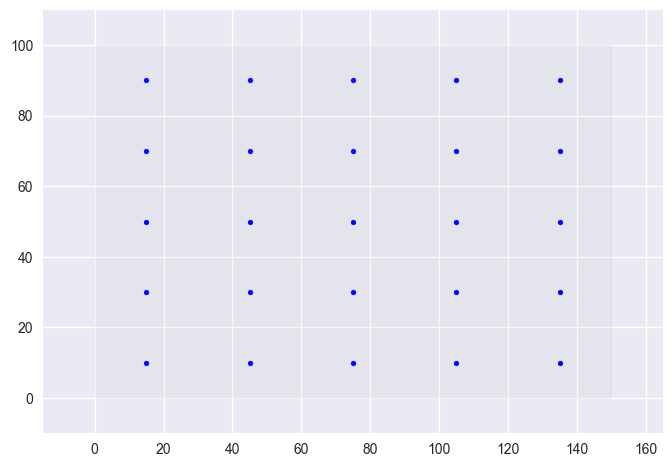

In [2]:
arange = SensorField(0,150,0,100)
arange.add_sensor_grid((5,5))
fig, ax = arange.display()

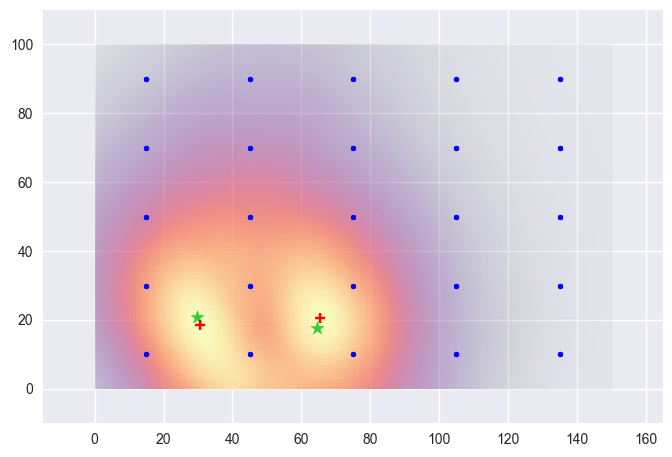

In [45]:
sigs = arange.gen_data(2, noise=4)
sigs.compute_distribution((150,100))
_, _ = sigs.display(exp_factor=0.0025, show_maxima=True)

In [8]:
def record_data_point(n=1):
    new_dat = []
    for _ in tqdm(range(n)):
        noise = 5*np.random.rand()
        sigs = arange.gen_data(2, noise=noise)
        sigs.compute_distribution((150,100))
        new_dat += [[noise, sigs.score()]]
    dat = np.load('dat.npy', allow_pickle=True)
    dat = np.concatenate((dat, np.array(new_dat)), axis=0)
    np.save('dat.npy', dat)

In [ ]:
record_data_point(1000)

 26%|██▌       | 262/1000 [11:58<33:53,  2.76s/it]

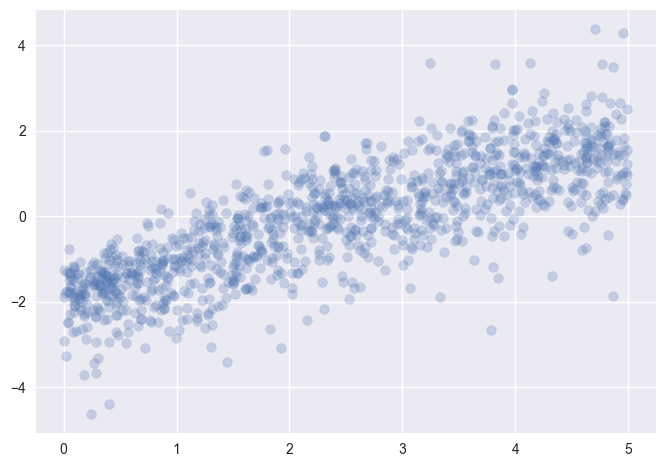

In [16]:
fig, ax = plt.subplots()
dat = np.load('dat.npy', allow_pickle=True)
print(dat.shape)
noise = dat[:, 0]
log_error = np.log(dat[:, 1])
ax.scatter(noise, log_error, alpha=0.25)